### **Credit Card Fraud Detection Using Unsupervised Anomaly Detection Methods**

In this project, we implement several unsupervised anomaly detection algorithms—including Isolation Forest, Local Outlier Factor (LOF), DBSCAN, and One-Class SVM—to detect fraudulent credit card transactions using a real-world dataset of European cardholder activity.

The [dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) contains transactions made by credit cards over two days by European cardholders. Each transaction is represented by a set of features derived from a PCA transformation of the original data. Unfortunately,
due to confidentiality concerns, we cannot provide the original features or further background details on the data. The dataset contains only numerical input variables:
* Features V1, V2, … V28: These are principal components obtained through PCA
transformation.
* Time: The time (in seconds) elapsed between each transaction and the first transaction in the dataset.
* Amount: The transaction Amount.

Since this is an unsupervised learning task, we do not use class labels during model training. Instead, we aim to detect anomalies based solely on the patterns in the input data. However, to evaluate the performance of each method and enable meaningful comparison, we utilize the available ground-truth labels only during the evaluation phase to compute metrics such as accuracy, precision, recall, and F1-score.

##### **Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN



In [ ]:
from google.colab import files
files.upload()

Saving creditcardfrauddetection.csv to creditcardfrauddetection.csv


##### **Load and Explore data**

In [ ]:
# Load the dataset
file_path = '/content/creditcardfrauddetection.csv'
data = pd.read_csv(file_path)

In [ ]:
data.shape

(284807, 31)

The dataset contains 284,807 rows and 31 columns, all of which are numerical.

In [ ]:
data.isnull().sum().sum()

0

There are no missing values in the dataset.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The data types are primarily float64 for numerical features and int64 for the Class column.

In [ ]:
descriptive_stats = data.describe()
descriptive_stats

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000




*   The count column shows that all features, including Time, V1 through V28, Amount, and Class, have 284,807 values, indicating there are no missing entries in the dataset.
*   The mean values for the PCA-transformed features (V1 to V28) are near zero, which is consistent with the characteristics of PCA transformation.

*   The Amount column has an average value of approximately 88.35, showing that the typical transaction amount is in this range.

*   The Class column's mean, 0.001727, indicates that fraudulent transactions make up only a small portion of the dataset, around 0.17%, **demonstrating the dataset's class imbalance.**

*   The std values represent the variability or spread of the data for each column. For example, the Amount column has a high standard deviation of 250.12, indicating a wide range of transaction amounts.

#### **EDA**

In this step, we create visualizations for key features (Time, Amount, and PCA features) to understand their distributions.

Text(0, 0.5, 'Frequency')

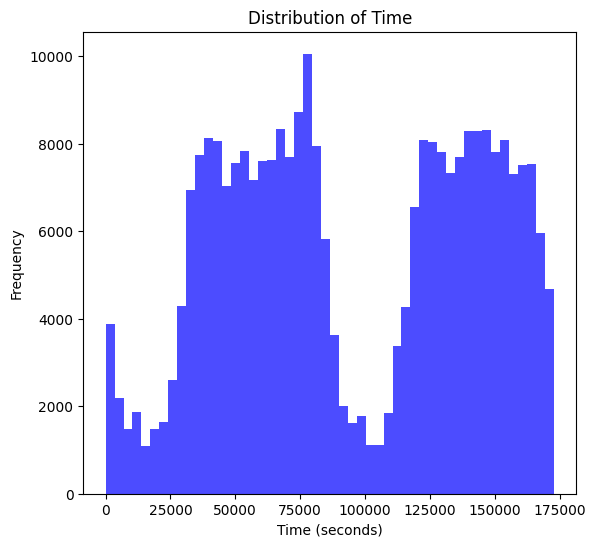

In [ ]:
# Visualization for 'Time' and 'Amount'
plt.figure(figsize=(14, 6))

# Time distribution
plt.subplot(1, 2, 1)
plt.hist(data['Time'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

The Time feature represents the elapsed time since the first transaction. Its distribution is uneven, with more transactions concentrated during specific time periods. This indicates potential temporal patterns in the data, such as peak activity during certain hours.

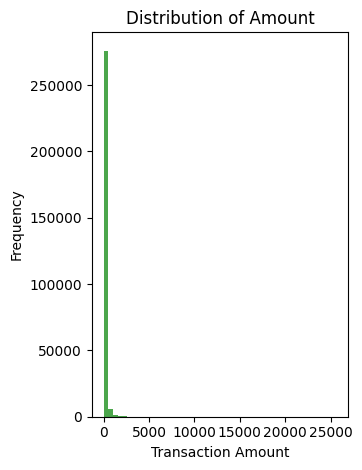

In [ ]:
# Amount distribution
plt.subplot(1, 2, 2)
plt.hist(data['Amount'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The Amount column shows a highly skewed distribution with a large number of small transactions and a few high-value transactions. This suggests the presence of outliers, which might impact anomaly detection algorithms.

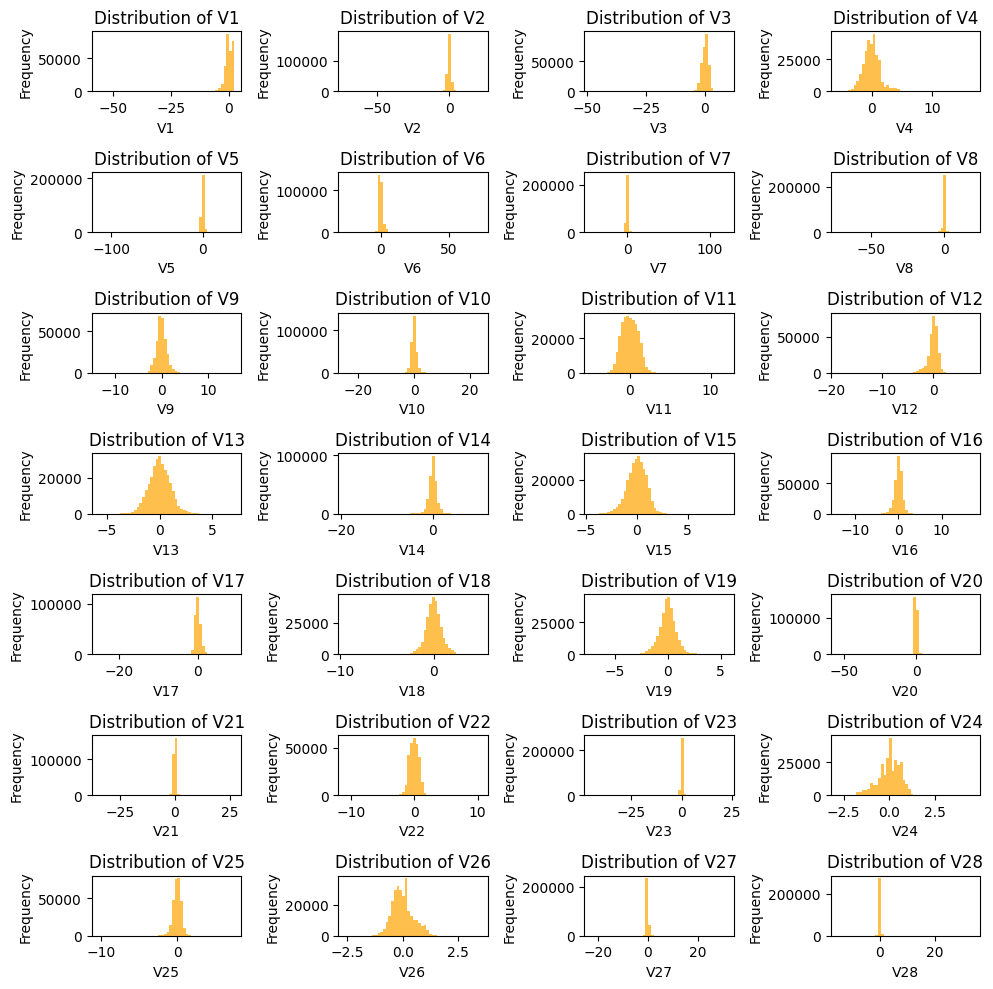

In [ ]:
# Visualization for PCA features
plt.figure(figsize=(10, 10))
for i in range(1, 29):  # V1 to V28
    plt.subplot(7, 4, i)
    plt.hist(data[f'V{i}'], bins=50, color='orange', alpha=0.7)
    plt.title(f'Distribution of V{i}')
    plt.xlabel(f'V{i}')
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()

The distributions of the PCA-transformed features vary. Most are approximately centered around zero with different spreads, consistent with the nature of PCA transformation. However, some features exhibit skewness or tails, indicating potential deviations in the data.

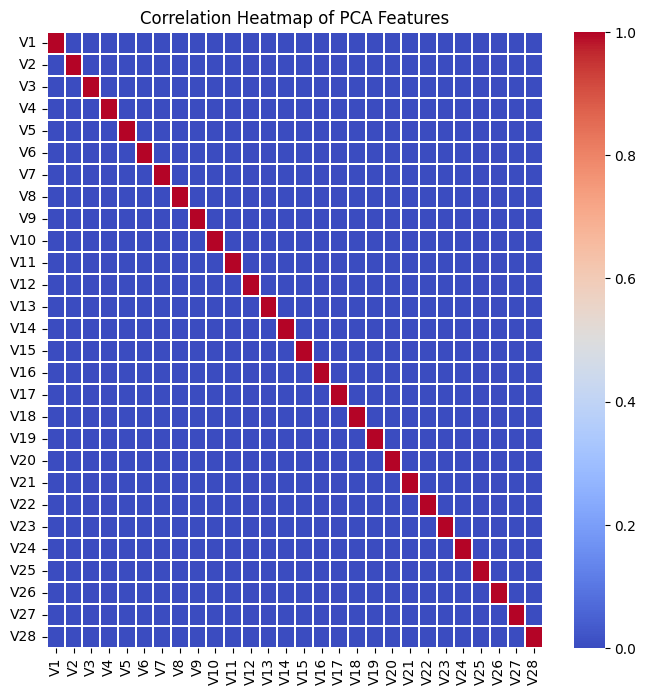

In [ ]:
# Correlation heatmap for PCA features
plt.figure(figsize=(8, 8))
correlation_matrix = data.iloc[:, 1:29].corr()  # Excluding 'Time', 'Amount', and 'Class'
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.1, annot=False)
plt.title('Correlation Heatmap of PCA Features')
plt.show()

The PCA-transformed features (V1 to V28) exhibit minimal correlation with each other, consistent with the PCA method, which aims to reduce multicollinearity.

<ipython-input-24-7b5ed1a7a403>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=data, palette='viridis')


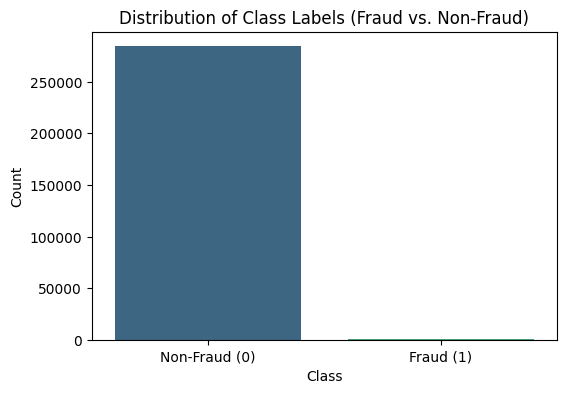

In [ ]:
# Distribution of 'Class' labels
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data, palette='viridis')
plt.title('Distribution of Class Labels (Fraud vs. Non-Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

The dataset is highly imbalanced, with a significant majority of transactions labeled as non-fraudulent (0) and only a small fraction as fraudulent (1). This confirms the need to evaluate metrics like precision and recall during model assessment.

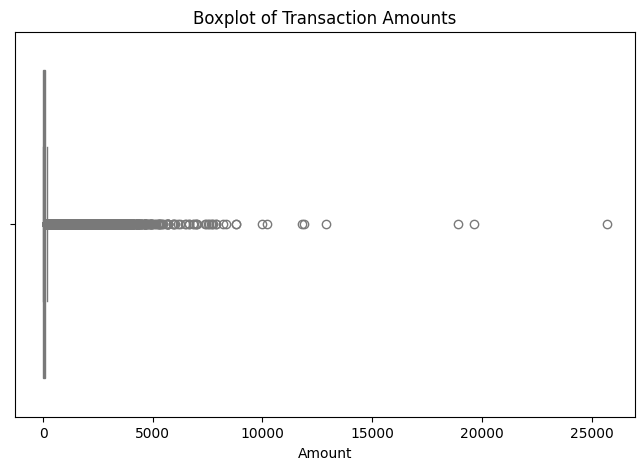

In [ ]:
# Boxplots for 'Amount' to visualize outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['Amount'], color='lightblue', orient='h')
plt.title('Boxplot of Transaction Amounts')
plt.xlabel('Amount')
plt.show()

The Amount feature contains many low-value transactions, but outliers are apparent, with some transactions having extremely high amounts.

In [ ]:
# Investigate high-value transactions
high_value_transactions = data[data['Amount'] > data['Amount'].quantile(0.99)]
high_value_transactions_summary = {
    "Count of High-Value Transactions": high_value_transactions.shape[0],
    "Fraudulent High-Value Transactions": high_value_transactions['Class'].sum(),
    "Non-Fraudulent High-Value Transactions": high_value_transactions.shape[0] - high_value_transactions['Class'].sum()
}
high_value_transactions_summary

{'Count of High-Value Transactions': 2849,
 'Fraudulent High-Value Transactions': 9,
 'Non-Fraudulent High-Value Transactions': 2840}

Transactions above the 99th percentile (amount > $397) include 2,849 observations. Of these, only 9 are fraudulent, indicating that most high-value transactions are legitimate. This suggests that transaction amount alone may not be a strong indicator of fraud.

#### **Data Splitting**

 To avoid data leakage, it is essential to separate the target variable (y) from the feature set (X) before scaling and any transformation which see entire data.

In [ ]:
# Separate features (X) and target (y)
X = data.drop(columns=['Class'])  # Features
y = data['Class']  # Target

#### **Log transformation**

 As observed in the histogram plots, several features (like Amount and some PCA-transformed features) exhibit skewness. Skewness can negatively impact the performance of anomaly detection algorithms, especially those that assume a Gaussian distribution (e.g., One-Class SVM and LOF).



So, I add  robust log transformations.

*   By compressing the range of larger values, log transformations reduce the effect of outliers.

*   This helps normalize the data, making it closer to a Gaussian distribution, which is advantageous for many machine learning algorithms.

*   After transformation, the features may align more closely with the assumptions of the detection models, improving their ability to distinguish anomalies from normal data.

*   Algorithms like Isolation Forest and LOF perform better when the data
distributions are less skewed. The transformation ensures that no single feature disproportionately influences the anomaly scores due to extreme values or skewness.

copy the DataFrame to avoid modifying the original data.

In [ ]:
df_transformed = data.copy()

Apply a log transformation (or log1p, which handles zero values gracefully) to reduce skewness.

In [ ]:
#log transformation function
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Compute skewness before transformation
skewness_before = data.skew()


For applying log transformation first I calculate skewness for all features (Time, Amount, V1 to V28), then select features with significant skewness (absolute skewness > 0.75) for transformation.

In [ ]:
#skewness > 0.75
for col in skewness_before[skewness_before.abs() > 0.75].index:
    df_transformed[col] = log_transform_skewed(data[col])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


After that recalculate skewness after transformation to confirm reduction.


In [ ]:
skewness_after = df_transformed.skew()

In [ ]:
# Create a comparison DataFrame
skewness_comparison = pd.DataFrame({
    'Skewness Before': skewness_before,
    'Skewness After': skewness_after
})
skewness_comparison

,Skewness Before,Skewness After
Time,-0.035568,-0.035568
V1,-3.280667,-0.364893
V2,-4.624866,-0.310128
V3,-2.240155,-0.315192
V4,0.676292,0.676292
V5,-2.425901,0.139077
V6,1.826581,0.804345
V7,2.553907,-0.112666
V8,-8.521944,-0.912642
V9,0.554680,0.554680


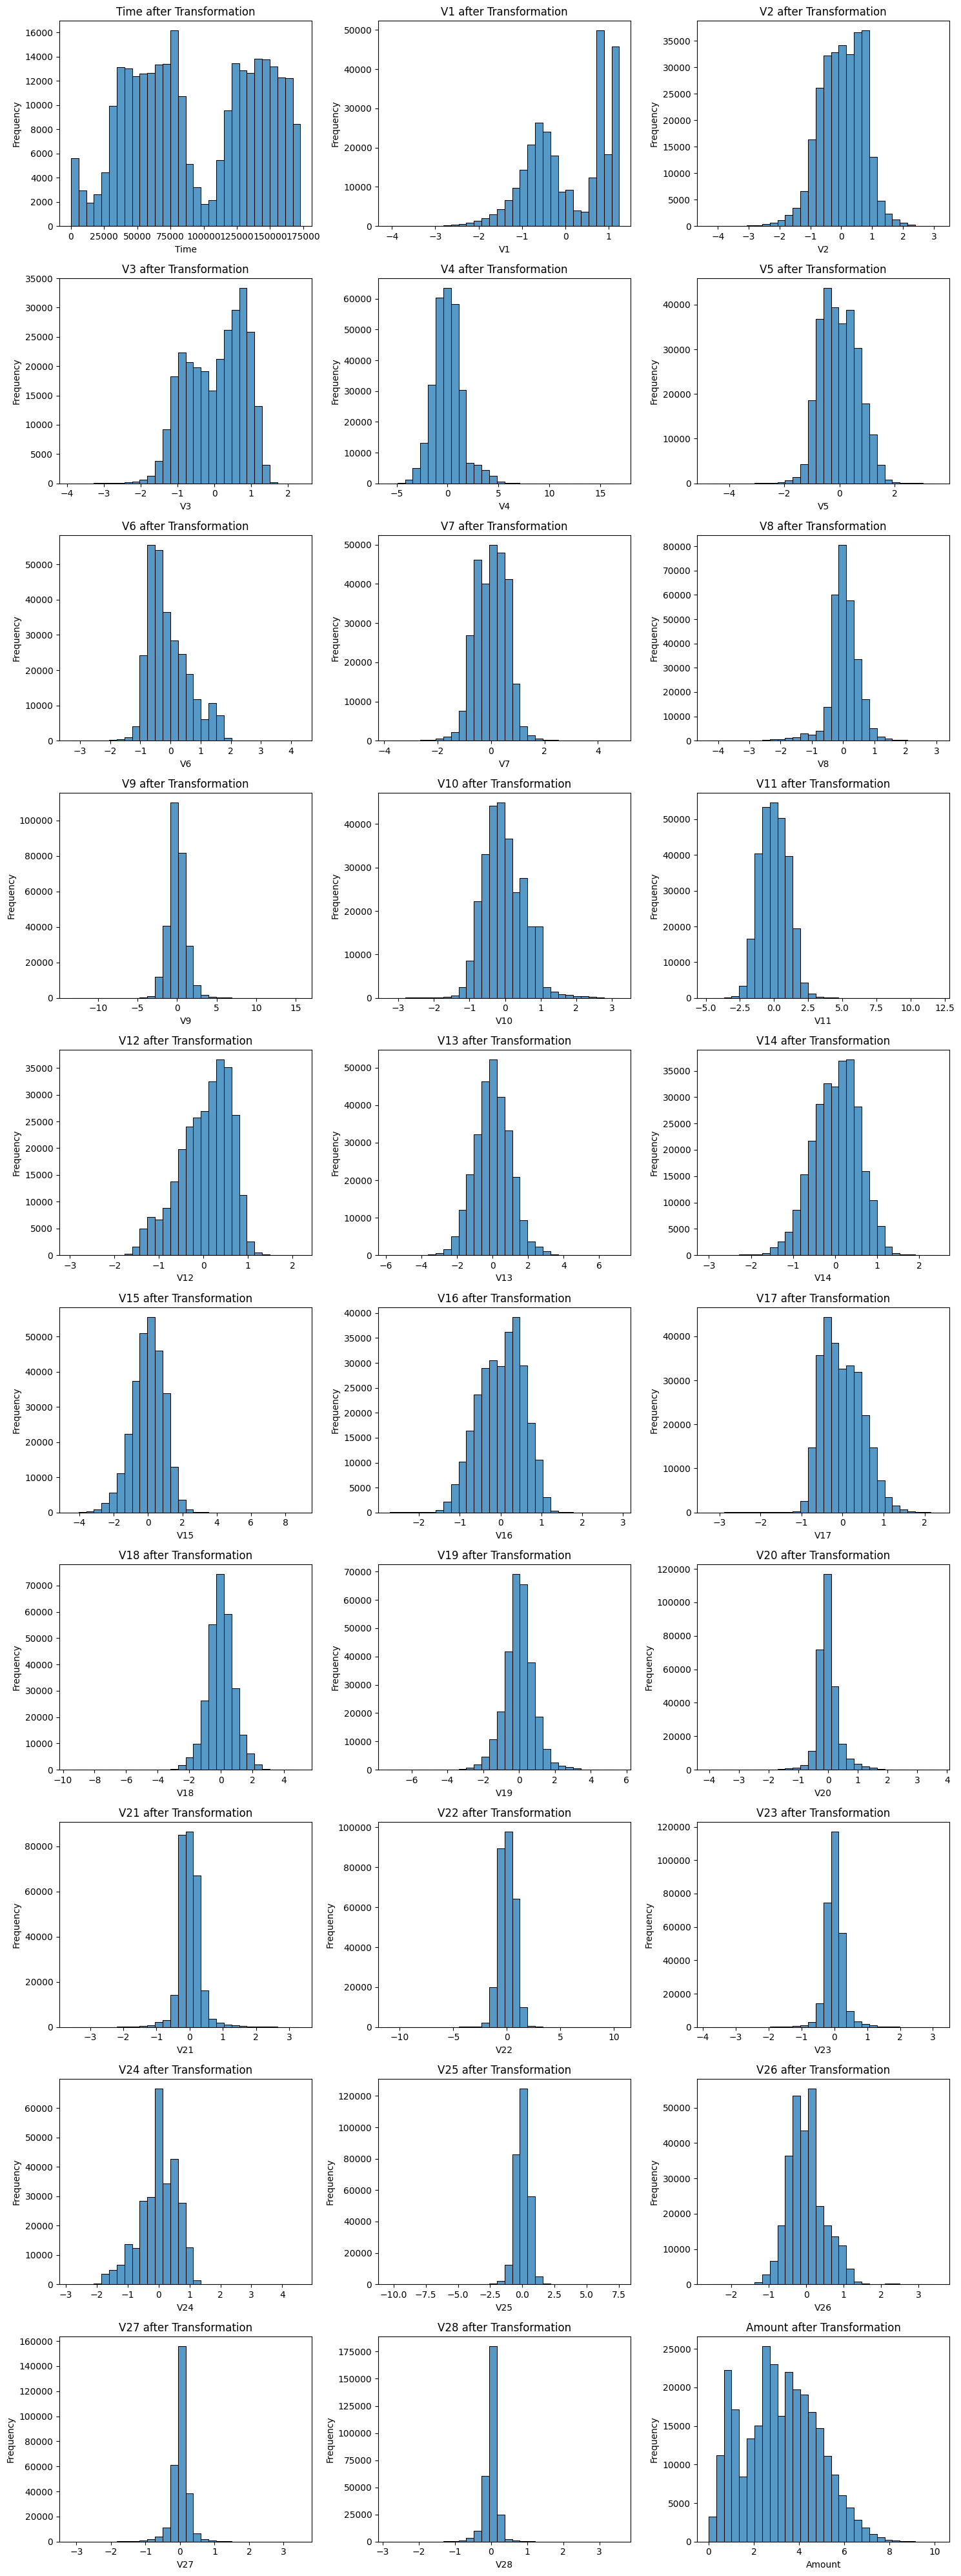

In [ ]:
features = data.columns[:-1]

fig, axes = plt.subplots(10, 3, figsize=(15, 40))  # Adjust rows to fit all features

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df_transformed[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'{feature} after Transformation')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if features < 30
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

The PCA features (V1 to V28) show significant improvement in their distributions after the log transformation. While they were initially highly skewed, they now resemble a more Gaussian-like distribution, aligning better with the assumptions of many detection models.

#### **Scaling**


I scaled the features using StandardScaler. The numerical features now have a mean of 0 and a standard deviation of 1, making them suitable for anomaly detection algorithms.

In [ ]:
# Standardize the features in X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#### **Isolation Forest**

Isolation Forest is an unsupervised anomaly detection algorithm designed to isolate data points that deviate significantly from the majority. It operates by randomly selecting features and thresholds to split the data, constructing decision trees. Anomalies, being distinct and sparse, tend to require fewer splits to isolate compared to normal data points. The model measures the path length in the tree required to isolate each data point, where shorter path lengths indicate potential anomalies.

This algorithm is efficient with high-dimensional data and does not assume any specific data distribution.

In the implementation, the contamination parameter is set to align with the known proportion of anomalies (fraudulent transactions) in the dataset, which is approximately 5%. After training, the model assigns scores to data points and labels them as normal or anomalous.

In [ ]:
# Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)  # Contamination aligns with fraud rate
isolation_forest.fit(X_scaled)

IsolationForest(contamination=0.05, random_state=42)

After training, the model predicts anomalies (-1) and normal points (1).


The predictions are converted to binary labels where anomalies (-1) become fraud (1), and normal points (1) become non-fraud (0).

In [ ]:
# Predict anomalies
predictions = isolation_forest.predict(X_scaled)
#-1 (anomaly) -> 1 (fraud), 1 (normal) -> 0 (non-fraud)
predictions = [1 if p == -1 else 0 for p in predictions]

For evaluation, the predictions are compared with the true fraud labels using metrics such as precision, recall, and F1-score.

In [ ]:
# Evaluate the results
conf_matrix = confusion_matrix(y, predictions)
class_report = classification_report(y, predictions, target_names=['Non-Fraud', 'Fraud'])
print("\nClassification Report:")
print(class_report)



Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.95      0.97    284315
       Fraud       0.03      0.85      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807



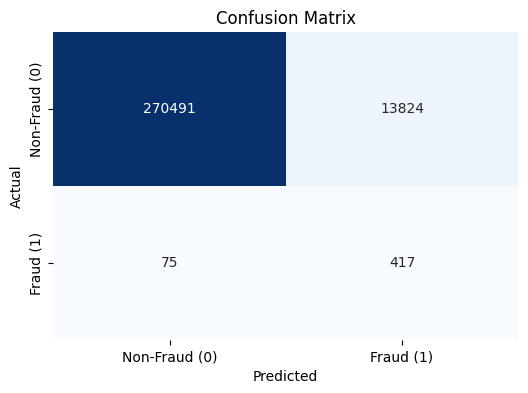

In [ ]:
# Confusion Matrix visualization
cm = confusion_matrix(y, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

* **Non-Fraud (True Negatives):**
27,491 transactions were correctly identified as non-fraud.


* **False Positives:**
13,824 transactions were incorrectly flagged as fraud when they were non-fraud. This high number of false positives can lead to unnecessary scrutiny of legitimate transactions.


* **False Negatives:**
75 fraudulent transactions were missed and labeled as non-fraud. These are the most critical errors in a fraud detection system since actual fraud goes undetected.


* **Fraud (True Positives):**
417 fraudulent transactions were correctly identified.

The ROC Curve shows the relationship between the True Positive Rate (TPR) and False Positive Rate (FPR).

<ipython-input-24-7b98d37813cf>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')


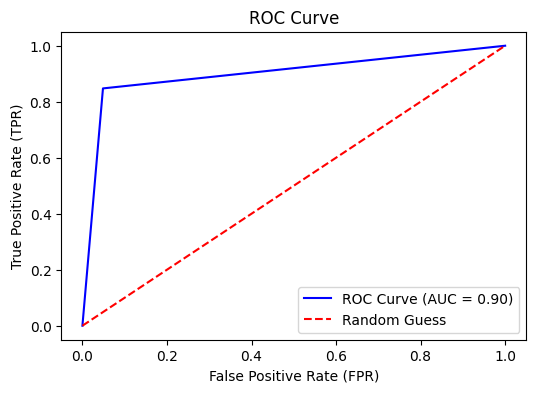

In [ ]:
# Calculate ROC AUC score
roc_auc = roc_auc_score(y, predictions)
# ROC Curve visualization
fpr, tpr, _ = roc_curve(y, predictions)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

The AUC Score (0.90) indicates that the model performs well overall. A perfect score is 1.0, and random guessing would achieve 0.5. A score of 0.90 suggests that the model is effective at distinguishing between fraud and non-fraud transactions, despite the high number of false positives.

#### **Local Outlier Factor (LOF)**

Local Outlier Factor (LOF) is an unsupervised anomaly detection algorithm that identifies anomalies by comparing the density of a data point to the densities of its neighbors. It assigns an anomaly score to each data point based on how isolated it is in its local neighborhood. Points with significantly lower density compared to their neighbors are considered anomalies.

 LOF computes the local density of a point based on the distance to its k-nearest neighbors and compares this density with the average density of its neighbors to calculate a Local Outlier Factor.

A value close to 1 indicates that the point has a similar density to its neighbors and is likely normal, while a value much greater than 1 indicates that the point is an anomaly.

In [ ]:
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05, novelty=False)  # Match fraud rate

LOF is particularly suited for datasets where anomalies occur in low-density regions and can handle situations where anomalies form clusters. However, its performance depends on the choice of parameters, such as the number of neighbors (n_neighbors) and the expected proportion of anomalies (contamination).

In [ ]:
# Fit and predict anomalies
lof_predictions = lof.fit_predict(X_scaled)

# Convert LOF predictions: -1 (anomaly) -> 1 (fraud), 1 (normal) -> 0 (non-fraud)
lof_predictions = [1 if p == -1 else 0 for p in lof_predictions]

In [ ]:
# Evaluate the results
lof_class_report = classification_report(y, lof_predictions, target_names=['Non-Fraud', 'Fraud'])
print("\nClassification Report:")
print(lof_class_report)


Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.95      0.97    284315
       Fraud       0.00      0.10      0.01       492

    accuracy                           0.95    284807
   macro avg       0.50      0.52      0.49    284807
weighted avg       1.00      0.95      0.97    284807



From the classification report, the precision for the fraud class is 0.00, meaning that the model rarely makes accurate predictions for fraudulent transactions. The recall for fraud is 0.10, indicating that only 10% of actual frauds are detected. This results in a very low F1-score of 0.01 for the fraud class.

On the other hand, the model achieves very high precision and recall for the non-fraud class due to the overwhelming majority of non-fraudulent transactions. However, this imbalance leads to poor detection of fraud and an overall accuracy that does not reflect the model's actual performance on the minority class.

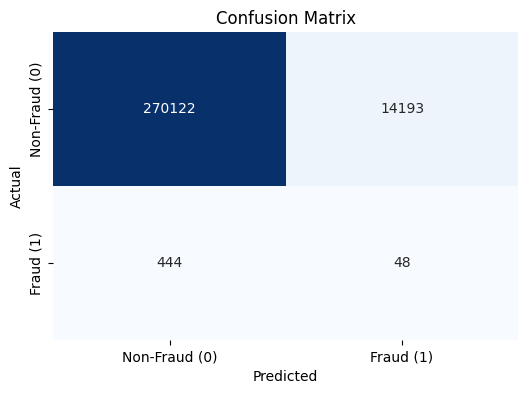

In [ ]:
lof_conf_matrix = confusion_matrix(y, lof_predictions)
# Confusion Matrix visualization
plt.figure(figsize=(6, 4))
sns.heatmap(lof_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

From the confusion matrix, out of 492 actual fraudulent transactions, only 48 were correctly identified as fraud, while 444 were misclassified as non-fraud. Among the non-fraudulent transactions, 270,122 were correctly identified, but 14,193 were falsely flagged as fraudulent.

<ipython-input-44-8edf368d22d0>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')


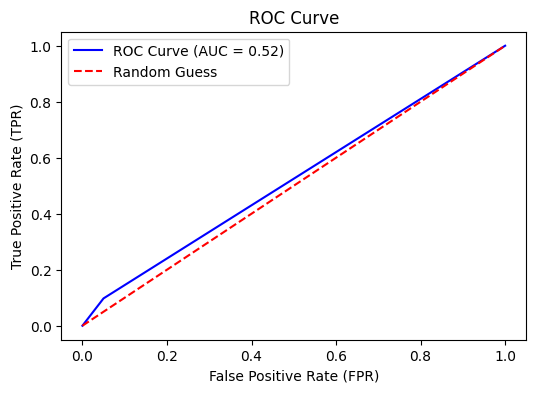

In [ ]:
# Calculate ROC AUC score
lof_roc_auc = roc_auc_score(y, lof_predictions)
# ROC Curve visualization
fpr, tpr, _ = roc_curve(y, lof_predictions)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {lof_roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

The ROC Curve shows an AUC score of 0.52, which is close to random guessing, indicating that the model struggles to differentiate between fraud and non-fraud cases.

#### **DBSCAN**

DBSCAN is a clustering algorithm that is also commonly used for anomaly detection. It groups points into clusters based on their density and labels points in low-density regions as anomalies.

DBSCAN relies on two key parameters:

* **eps (Epsilon):** Defines the radius within which points are considered neighbors.


* **min_samples:**The minimum number of points (including the point itself) required to form a dense region.

The algorithm starts by visiting an unvisited point. If the point has enough neighbors (≥ min_samples) within eps, it forms a cluster. Otherwise, the point is labeled as noise or an  anomaly.

Points are categorized as:

* **Core Points:** Points with at least min_samples neighbors within the eps radius. These form the heart of a cluster.


* **Border Points:** Points that are within the eps radius of a core point but have fewer than min_samples neighbors themselves.


* **Noise Points:** Points that do not fall into any cluster or neighborhood. These are considered anomalies.

In [ ]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', n_jobs=-1)

In [ ]:
# Fit DBSCAN
dbscan_labels = dbscan.fit_predict(X_scaled)

#-1 (noise/anomaly) -> 1 (fraud), others -> 0 (non-fraud)
dbscan_predictions = [1 if label == -1 else 0 for label in dbscan_labels]


In [ ]:
# Evaluate DBSCAN results
dbscan_class_report = classification_report(y, dbscan_predictions, target_names=['Non-Fraud', 'Fraud'])
print("\nClassification Report:")
print(dbscan_class_report)


Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.23      0.38    284315
       Fraud       0.00      0.98      0.00       492

    accuracy                           0.24    284807
   macro avg       0.50      0.61      0.19    284807
weighted avg       1.00      0.24      0.38    284807



The classification report reveals that the precision for fraud is 0.00, which means that many transactions flagged as fraudulent are false positives.

The recall for fraud is 0.98, indicating that DBSCAN successfully identifies nearly all fraudulent transactions, but the precision issue suggests that the model over-flags anomalies.

 For non-fraud transactions, the recall drops to 0.23 , meaning it only identifies 23% of non-fraud cases correctly, while the precision is very high due to the large number of true negatives relative to the false positives.

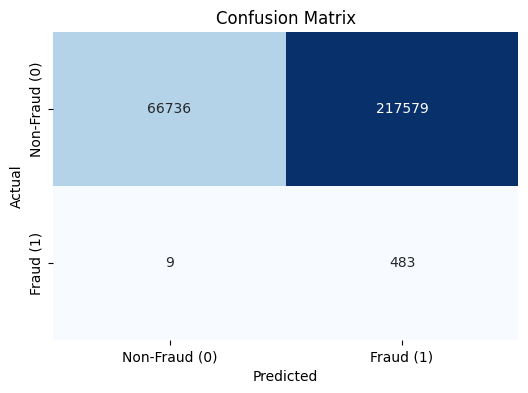

In [ ]:
dbscan_conf_matrix = confusion_matrix(y, dbscan_predictions)
# Confusion Matrix visualization
plt.figure(figsize=(6, 4))
sns.heatmap(dbscan_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

The confusion matrix shows that out of 492 actual fraud cases, 483 were correctly identified as fraud (true positives), demonstrating strong performance in identifying fraudulent transactions. However, 9 fraud cases were misclassified as non-fraud (false negatives), which is relatively low.

 On the other hand,out of 284,315 non-fraudulent transactions, only 66,736 were correctly identified as non-fraud (true negatives), while a large portion, 217,579, was incorrectly flagged as fraud (false positives).

<ipython-input-49-e1f0727151f3>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')


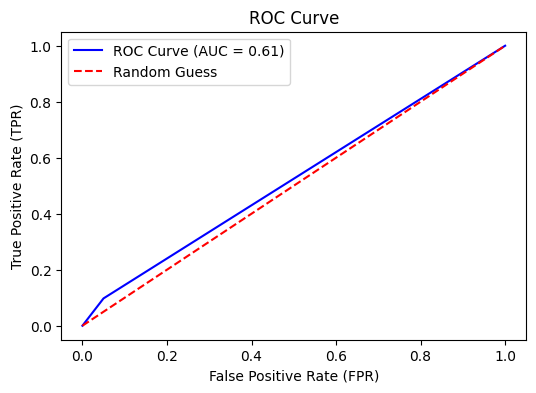

In [ ]:
dbscan_roc_auc = roc_auc_score(y, dbscan_predictions)
# ROC Curve visualization
fpr, tpr, _ = roc_curve(y, lof_predictions)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {dbscan_roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

The ROC AUC score is 0.61, which is better than random guessing but far from satisfactory. This indicates limited discriminatory power between fraud and non-fraud cases.

DBSCAN effectively detects fraud (high recall for fraud), making it sensitive to anomalies in the data.


However, the high number of false positives significantly reduces its utility, as over 76% of non-fraudulent transactions are flagged incorrectly.


The overall accuracy is very low at 24%, reflecting the high misclassification rate for non-fraudulent transactions.

Refining DBSCAN parameters - Experiment with different `eps` and `min_samples`


In [ ]:
best_eps = None
best_min_samples = None
best_auc = 0
results = []

# Grid search over a range of `eps` and `min_samples`
for eps in [0.5, 1.0, 1.5, 2.0]:
    for min_samples in [5, 10, 15, 20]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
        dbscan_labels = dbscan.fit_predict(X_scaled)

        # Convert DBSCAN labels to binary format (1 = fraud, 0 = non-fraud)
        dbscan_predictions = [1 if label == -1 else 0 for label in dbscan_labels]

        # Calculate metrics
        try:
            auc_score = roc_auc_score(y, dbscan_predictions)
        except ValueError:
            auc_score = 0  # Handle cases with no anomalies detected
        results.append((eps, min_samples, auc_score))

        # Update best parameters
        if auc_score > best_auc:
            best_eps = eps
            best_min_samples = min_samples
            best_auc = auc_score

In [ ]:
# Compile results into a DataFrame
import pandas as pd
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'ROC AUC'])

import ace_tools as tools; tools.display_dataframe_to_user(name="DBSCAN Parameter Tuning Results", dataframe=results_df)

What the Code Does:
Parameter Tuning:

The code runs a grid search over a range of eps (radius) and min_samples (minimum points to form a dense region).
It calculates the ROC AUC score for each combination of eps and min_samples.
Optimal Parameters:

The code tracks the combination of eps and min_samples that produces the highest ROC AUC score.
Results are compiled into a DataFrame for easy analysis.
Output:

You’ll get a DataFrame showing the eps, min_samples, and corresponding ROC AUC scores for each combination.
The best-performing parameters (best_eps, best_min_samples) are identified.

#### **One-Class SVM**

One-Class SVM is a boundary-based anomaly detection method. It works by learning the boundary of the majority class (normal data) in the feature space and then identifying points that fall outside this boundary as anomalies.



Fit the model to the scaled feature set (X_scaled) to learn the boundary of the normal transactions.

I use the  rbf kernel parameter to control the model's decision boundary.

In [ ]:
# Initialize One-Class SVM
one_class_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma=0.001)  # `nu` approximates the anomaly proportion
# Fit the model to the scaled data
one_class_svm.fit(X_scaled)

OneClassSVM(gamma=0.001, nu=0.05)

Then I use the model to predict whether transactions are normal or anomalies, and like all methods convert the output (1 for normal, -1 for anomalies) to fraud labels (1 for fraud, 0 for non-fraud).

In [ ]:
# Predict anomalies
svm_predictions = one_class_svm.predict(X_scaled)
# Convert One-Class SVM outputs: -1 (anomaly) -> 1 (fraud), 1 (normal) -> 0 (non-fraud)
svm_predictions = [1 if p == -1 else 0 for p in svm_predictions]

In [ ]:
svm_class_report = classification_report(y, svm_predictions, target_names=['Non-Fraud', 'Fraud'])
print("\nClassification Report:")
print(svm_class_report)


Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.95      0.97    284315
       Fraud       0.03      0.87      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807



The precision for fraud is 0.03, which indicates that the majority of transactions flagged as fraud are actually non-fraud (high False Positives).

However, the recall for fraud is 0.87, showing that 87% of actual fraud cases are successfully detected. This high recall is crucial in fraud detection, where missing a fraud case (False Negative) is often more costly than a False Positive.

The F1-score for fraud is low (0.06) due to the trade-off between precision and recall. For non-fraudulent transactions, the model achieves a high precision, recall, and F1-score, reflecting its strong ability to classify the majority class correctly.

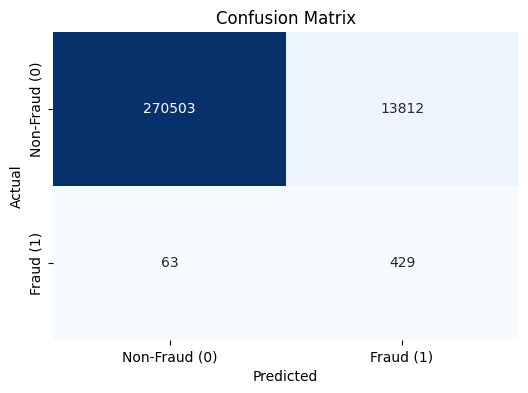

In [ ]:
svm_conf_matrix = confusion_matrix(y, svm_predictions)
# Confusion Matrix visualization
plt.figure(figsize=(6, 4))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

Out of 492 actual fraudulent transactions:

* 429 were correctly identified as fraud (True Positives).

* 63 were misclassified as non-fraud (False Negatives).

Out of 284,315 non-fraudulent transactions:

* 270,503 were correctly classified as non-fraud (True Negatives).

* 13,812 were incorrectly flagged as fraud (False Positives).

The model is effective at detecting fraudulent transactions, though it still flags a significant number of non-fraudulent transactions as fraud.



<ipython-input-58-e46420195c14>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')


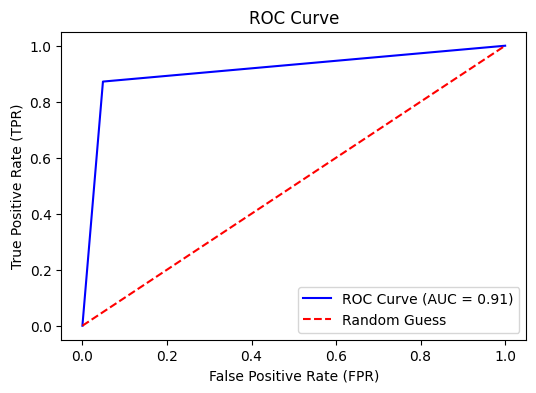

In [ ]:
# Calculate ROC AUC score
svm_roc_auc = roc_auc_score(y, svm_predictions)
# ROC Curve visualization
fpr, tpr, _ = roc_curve(y, svm_predictions)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {svm_roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

The ROC curve shows an AUC score of 0.91, indicating that the model is effective at distinguishing between fraudulent and non-fraudulent transactions. This is a strong performance, suggesting that One-Class SVM is well-suited for this dataset.



#### **Comparing the results of different methods:**

In [ ]:
summary_results = pd.DataFrame({
    "Model": ["Isolation Forest", "LOF", "DBSCAN", "One-Class SVM"],
    "Precision (Fraud)": [0.03, 0.00, 0.00, 0.03],
    "Recall (Fraud)": [0.85, 0.10, 0.98, 0.87],
    "F1-Score (Fraud)": [0.06, 0.01, 0.00, 0.06],
    "ROC AUC": [0.90, 0.52, 0.61, 0.91],
    "False Positives": [13824, 14193, 217579, 13812],
    "False Negatives": [75, 444, 9, 63]
})

print(summary_results.to_string(index=False))

           Model  Precision (Fraud)  Recall (Fraud)  F1-Score (Fraud)  ROC AUC  False Positives  False Negatives
Isolation Forest               0.03            0.85              0.06     0.90            13824               75
             LOF               0.00            0.10              0.01     0.52            14193              444
          DBSCAN               0.00            0.98              0.00     0.61           217579                9
   One-Class SVM               0.03            0.87              0.06     0.91            13812               63


In [ ]:
# Metrics for comparison
models = ["Isolation Forest", "LOF", "DBSCAN", "One-Class SVM"]
precision = [0.03, 0.00, 0.00, 0.03]
recall = [0.85, 0.10, 0.98, 0.87]
f1_score = [0.06, 0.01, 0.00, 0.06]
roc_auc = [0.90, 0.52, 0.61, 0.91]

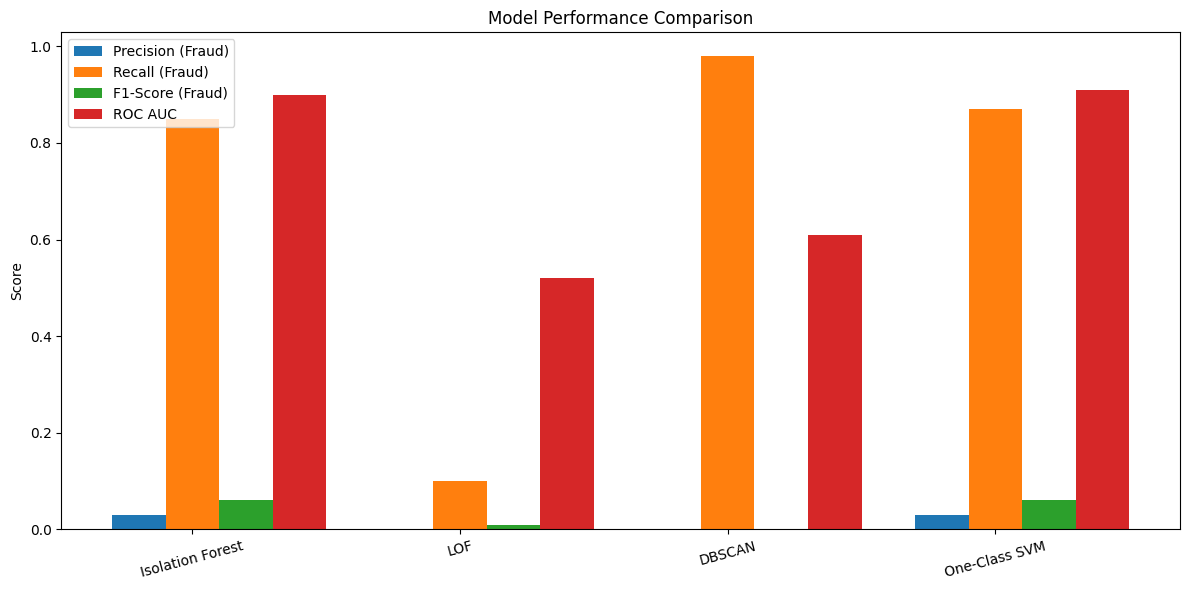

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
positions = range(len(models))

# Plot bars
ax.bar([p - bar_width for p in positions], precision, bar_width, label="Precision (Fraud)")
ax.bar(positions, recall, bar_width, label="Recall (Fraud)")
ax.bar([p + bar_width for p in positions], f1_score, bar_width, label="F1-Score (Fraud)")
ax.bar([p + 2 * bar_width for p in positions], roc_auc, bar_width, label="ROC AUC")

# Add labels, title, and legend
ax.set_xticks(positions)
ax.set_xticklabels(models, rotation=15)
ax.set_title("Model Performance Comparison")
ax.set_ylabel("Score")
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


The bar chart compares the performance of the four anomaly detection models (Isolation Forest, LOF, DBSCAN, and One-Class SVM) based on Precision, Recall, F1-Score for fraud detection, and ROC AUC.

**Precision (Fraud):**

All models have low precision, indicating a high rate of false positives among the predicted fraud cases.
Isolation Forest and One-Class SVM perform slightly better (0.03) than LOF and DBSCAN, which fail to correctly identify any fraudulent transactions.

**Recall (Fraud):**

DBSCAN has the highest recall (0.98), meaning it identifies 98% of actual fraud cases. However, its extremely low precision suggests it falsely labels a large number of non-fraud cases as fraud.
One-Class SVM and Isolation Forest also achieve high recall values (0.87 and 0.85, respectively), making them effective in minimizing false negatives.
LOF struggles with recall, capturing only 10% of fraud cases.

**F1-Score (Fraud):**

Due to the trade-off between precision and recall, all models have very low F1-scores. This highlights the difficulty of achieving a balance between minimizing false positives and false negatives in fraud detection.


**ROC AUC:**

One-Class SVM and Isolation Forest have the highest ROC AUC scores (0.91 and 0.90, respectively), indicating that they are the most effective overall at distinguishing between fraud and non-fraud cases.
DBSCAN follows with an ROC AUC of 0.61, while LOF performs poorly with an ROC AUC of 0.52, barely better than random guessing.


#### **Models' Performance**

*   **Isolation Forest and One-Class SVM:**
These two models achieve the best balance between recall and overall model performance(ROC AUC), making them the most promising candidates for fraud detection.
Both models sacrifice precision (many false positives) to ensure high recall, which is often acceptable in fraud detection scenarios where missing fraudulent cases (false negatives) is costly.

*   **DBSCAN:**
Excellent recall but the overwhelming number of false positives (poor precision) makes it impractical in real-world applications without significant refinement.

*   **LOF:**
Struggles across all metrics, with low recall, precision, and ROC AUC, indicating it is not suitable for this task.



#### **Autoencoder**

Autoencoders are neural networks designed to learn compressed representations of data. They are effective for anomaly detection by leveraging the difference between reconstruction errors of normal and anomalous data.
 Autoencoders are particularly useful for high-dimensional data like the credit card fraud dataset. They learn to reconstruct normal transactions well while failing to reconstruct anomalies accurately, as anomalies do not align with the learned patterns.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

The encoder compresses the input into a lower-dimensional latent space.
The decoder reconstructs the input data from the latent representation.
This process helps the model learn the underlying patterns in the data.

In [ ]:
#Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize
input_dim = X_scaled.shape[1]
model = Autoencoder(input_dim)
print(model)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=30, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
# Convert data to NumPy arrays
X_numpy = X_scaled.to_numpy()  # Convert X_scaled DataFrame to a NumPy array
y_numpy = y.to_numpy()         # Convert y Series to a NumPy array

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
y_tensor = torch.tensor(y_numpy, dtype=torch.float32)

# Select only non-fraudulent transactions for training
normal_data = X_tensor[y_tensor == 0]  # Non-fraudulent transactions

# Verify the size of normal data
print(f"Shape of normal data for training: {normal_data.shape}")


Shape of normal data for training: torch.Size([284315, 30])


The model is trained for 50 epochs with a batch size of 32 using the Mean Squared Error (MSE) loss function and the Adam optimizer.

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training parameters
epochs = 50
batch_size = 32

# Training loop
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(normal_data.size(0))  # Shuffle data
    epoch_loss = 0.0

    for i in range(0, normal_data.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_data = normal_data[indices]

        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(normal_data):.6f}")


Epoch 1/50, Loss: 0.025472
Epoch 2/50, Loss: 0.023841
Epoch 3/50, Loss: 0.023558
Epoch 4/50, Loss: 0.023375
Epoch 5/50, Loss: 0.023221
Epoch 6/50, Loss: 0.023130
Epoch 7/50, Loss: 0.023051
Epoch 8/50, Loss: 0.022971
Epoch 9/50, Loss: 0.022932
Epoch 10/50, Loss: 0.022908
Epoch 11/50, Loss: 0.022893
Epoch 12/50, Loss: 0.022865
Epoch 13/50, Loss: 0.022851
Epoch 14/50, Loss: 0.022836
Epoch 15/50, Loss: 0.022826
Epoch 16/50, Loss: 0.022816
Epoch 17/50, Loss: 0.022809
Epoch 18/50, Loss: 0.022804
Epoch 19/50, Loss: 0.022796
Epoch 20/50, Loss: 0.022793
Epoch 21/50, Loss: 0.022789
Epoch 22/50, Loss: 0.022782
Epoch 23/50, Loss: 0.022778
Epoch 24/50, Loss: 0.022776
Epoch 25/50, Loss: 0.022770
Epoch 26/50, Loss: 0.022765
Epoch 27/50, Loss: 0.022765
Epoch 28/50, Loss: 0.022760
Epoch 29/50, Loss: 0.022754
Epoch 30/50, Loss: 0.022745
Epoch 31/50, Loss: 0.022735
Epoch 32/50, Loss: 0.022727
Epoch 33/50, Loss: 0.022716
Epoch 34/50, Loss: 0.022716
Epoch 35/50, Loss: 0.022709
Epoch 36/50, Loss: 0.022709
E

After training, the reconstruction error is calculated for all transactions.
Fraudulent transactions typically have higher reconstruction errors because the model is not trained on them.

In [ ]:
#Compute reconstruction errors for all data
model.eval()
with torch.no_grad():
    reconstructed = model(X_tensor)
    reconstruction_errors = torch.mean((X_tensor - reconstructed) ** 2, axis=1).numpy()

#Set a 95th percentile of errors
threshold = np.percentile(reconstruction_errors, 95)  # Top 5% of errors are anomalies
print(f"Threshold for anomaly detection: {threshold}")

#Predict anomalies
autoencoder_predictions = [1 if error > threshold else 0 for error in reconstruction_errors]

Threshold for anomaly detection: 2.213095712661744


In [ ]:
#results
class_report = classification_report(y, autoencoder_predictions, target_names=['Non-Fraud', 'Fraud'])
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.95      0.97    284315
       Fraud       0.03      0.87      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807



Precision (Fraud: 0.03):
Out of all transactions flagged as fraud, only 3% are actual frauds, indicating a high false positive rate.

Recall (Fraud: 0.87):
The model successfully identifies 87% of fraudulent transactions, minimizing false negatives.

F1-Score (Fraud: 0.06):
The F1-score is low due to the imbalance between precision and recall.

Accuracy (0.95):
The high accuracy is due to the dominance of the non-fraudulent class.

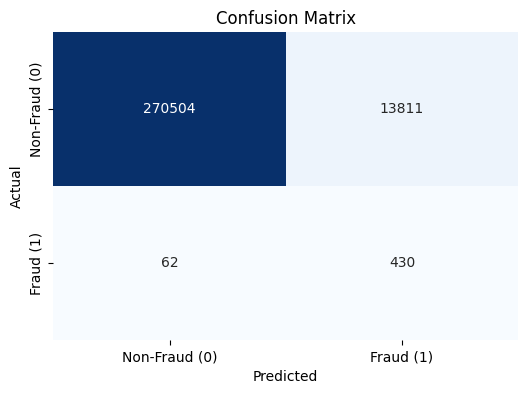

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y, autoencoder_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

* **True Negatives** (270,504): Non-fraudulent transactions correctly classified.

* **False Positives** (13,811): Non-fraudulent transactions incorrectly classified as fraudulent.

* **True Positives** (430): Fraudulent transactions correctly identified.

* **False Negatives**(62): Fraudulent transactions missed by the model.

<ipython-input-42-ea8efe89a894>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')


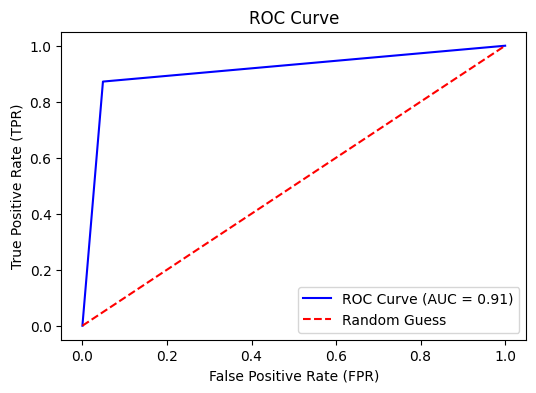

In [ ]:
# ROC Curve visualization
roc_auc = roc_auc_score(y, autoencoder_predictions)
fpr, tpr, _ = roc_curve(y, autoencoder_predictions)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

 AUC score of 0.91 indicating excellent performance.


One-Class SVM and Autoencoder both achieve the highest ROC AUC (0.91), demonstrating strong discriminatory power.

The Autoencoder and One-Class SVM have the fewest false positives after DBSCAN but are still high, highlighting the trade-off between precision and recall.

DBSCAN achieves the highest recall (0.98), detecting almost all fraudulent transactions, but it has a massive number of false positives (217,579), making it impractical.